# A Small Residual Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
#from torchsummary import summary
import timeit

## Downloading the CIFAR10 Dataset and Visualization

In [2]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


## Dataset and Dataloader

In [3]:
th.manual_seed(43)

# We use about 20% of the dataset for validation.
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print("Data sizes after random splitting -> ", "\nTraining data size = ",len(train_ds), "\nValidation data size = ", len(val_ds))

batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_dataset, batch_size*2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Data sizes after random splitting ->  
Training data size =  40000 
Validation data size =  10000


images.shape: torch.Size([128, 3, 32, 32])


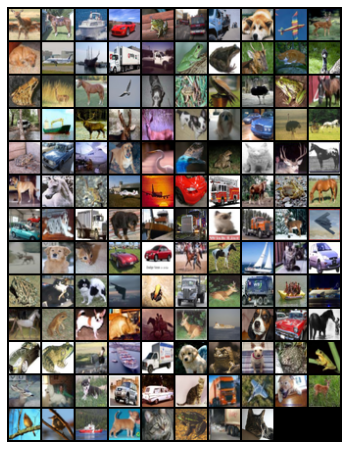

In [4]:
#Visualization of dataset in batches
for index, (images, labels) in enumerate(train_loader):
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))
    if index == 0:  #number of batches to visualize
      break

## Device Settings

In [6]:
device = th.device('cuda')   #cuda or cpu
print(device)
print(th.cuda.device_count())

cuda
1


## Network Class

In [39]:
class ResBlock(th.nn.Module):
    def __init__(self, in_features):
        super(ResBlock, self).__init__()
        self.in_features = in_features
        
        self.conv1 = nn.Conv2d(self.in_features, self.in_features, 3, padding=1)
        self.conv2 = nn.Conv2d(self.in_features, self.in_features, 3, padding=1)
            
    def forward(self, x):
        H = F.relu(self.conv1(x))
        H = self.conv2(H)
        x = F.relu(H + x)
        return x
    
resblock = ResBlock(3)
resblock(th.rand((1,3,7,5))).shape

torch.Size([1, 3, 7, 5])

In [40]:
class ResNet(th.nn.Module):
    def __init__(self, in_channels, num_classes, num_blocks):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_blocks = num_blocks

        self.activation = nn.ReLU()
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(3, in_channels[0], 7, stride=2, padding=3))
        self.layers.append(self.activation)
        for i in range(len(in_channels)-1):
            ResBlock(in_channels[i])
            self.layers.append(nn.Conv2d(in_channels[i], in_channels[i+1], 3, padding=1))
            self.layers.append(self.activation)
        self.layers.append(ResBlock(in_channels[-1]))
        self.layers.append(nn.AvgPool2d(2))
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(self.in_channels[-1]*8*8, self.num_classes))
         
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

resnet = ResNet(in_channels=[32,64,128], num_classes=10, num_blocks=3)
resnet(th.rand((2, 3, 32, 32))).shape

torch.Size([2, 10])

In [41]:
model = ResNet(in_channels=[32,64,128], num_classes=10, num_blocks=3).to(device=device)
print(model)

ResNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=8192, out_features=10, bias=True)
  )
)


## Model Loading

In [ ]:
loaded_model = Network().to(device=device)
loaded_model.load_state_dict(th.load("savedModels/Resnet_model"))

## Train Function and Evaluate Function

In [51]:
def train(model, dataloader, optimizer, lossFunction, device=th.device('cpu'), debug=False):
    loss_hist = np.array([])
    total_acc = 0.0

    for index, (images, labels) in enumerate(dataloader):
        #zero the parameter gradients
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        prediction = model(images)
        loss = lossFunction(prediction, labels)
        loss_hist = np.append(loss_hist, loss.item())
        loss.backward()
        optimizer.step()
        
        #accuracy
        pred_label = th.argmax(prediction, dim=1)  #hardmax
        acc = ((pred_label==labels).sum().item() / len(labels))
        total_acc += acc

        if debug: 
            with th.no_grad():
                if index % 100 == 0:
                    print("{}/{} Loss:{:.6f}".format(index, len(dataloader), loss.item()))

    return total_acc/len(dataloader), loss_hist

def evaluate(model, dataloader, lossFunction, device=th.device('cuda')):   

    total_loss = 0
    total_acc = 0.0

    for index, (images, labels) in enumerate(dataloader):

        images = images.to(device)
        labels = labels.to(device)
        
        prediction = model(images)
        loss = lossFunction(prediction, labels)
        total_loss += loss.item()

        pred_label = th.argmax(prediction, dim=1)  #hardmax
        acc = ((pred_label==labels).sum().item() / len(labels))
        total_acc += acc

    return total_acc/len(dataloader), total_loss/len(dataloader)

## Optimizer and Loss Function

In [42]:
optimizer = th.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95))

lossFunction = th.nn.CrossEntropyLoss()

## Main Module

In [43]:
training_loss_hist = np.array([])
valid_loss_hist = np.array([])
valid_acc_hist = np.array([])

epoch = 25

start_time = timeit.default_timer()

for i in range(epoch):
        #training
        train_acc, train_loss = train(model, train_loader, optimizer, lossFunction, device=device, debug=False)

        #evaluation
        avg_acc, avg_loss = evaluate(model, val_loader, lossFunction, device=device)

        # loss and accuracy histories are kept
        training_loss_hist = np.append(training_loss_hist, train_loss)
        valid_loss_hist = np.append(valid_loss_hist, avg_loss)
        valid_acc_hist = np.append(valid_acc_hist, avg_acc)

        print("epoch {} validation loss: {} validation acc: {}".format(i, avg_loss, avg_acc) )

stop_time = timeit.default_timer()

print("Time: ", stop_time-start_time)

epoch 0 evaluation loss: 1.5120310634374619 evaluation acc: 0.45048828125
epoch 1 evaluation loss: 1.402122548222542 evaluation acc: 0.4943359375
epoch 2 evaluation loss: 1.270401281118393 evaluation acc: 0.5498046875
epoch 3 evaluation loss: 1.2047793775796891 evaluation acc: 0.57255859375
epoch 4 evaluation loss: 1.1421818673610686 evaluation acc: 0.59404296875
epoch 5 evaluation loss: 1.0568070605397224 evaluation acc: 0.63125
epoch 6 evaluation loss: 1.0044981613755226 evaluation acc: 0.648828125
epoch 7 evaluation loss: 0.9444190666079522 evaluation acc: 0.66875
epoch 8 evaluation loss: 0.9578581526875496 evaluation acc: 0.66796875
epoch 9 evaluation loss: 0.9120967745780945 evaluation acc: 0.69072265625
epoch 10 evaluation loss: 0.9608223408460617 evaluation acc: 0.67421875
epoch 11 evaluation loss: 0.9305438742041587 evaluation acc: 0.69140625
epoch 12 evaluation loss: 0.9022129461169243 evaluation acc: 0.6970703125
epoch 13 evaluation loss: 0.9080136761069297 evaluation acc: 0.

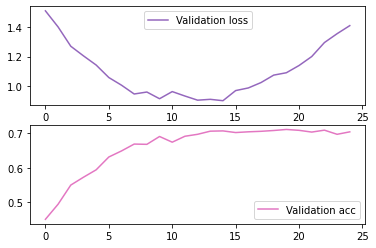

In [44]:
fig, (axs1, axs2) = plt.subplots(2)
axs1.plot(valid_loss_hist, "tab:purple", label="Validation loss")
axs1.legend()
axs2.plot(valid_acc_hist, "tab:pink", label="Validation acc")
axs2.legend()

In [45]:
test_acc, test_loss = evaluate(model, val_loader, lossFunction, device=device)
print("test accuracy: {} , test loss: {}".format(test_acc, test_loss))

test accuracy: 0.70419921875 , test loss: 1.4111854404211044


## Model Saving

In [46]:
th.save(model.state_dict(), "Resnet_model")

# Towards a competitive CIFAR-10 classifier

Another Solutions can be:
- Leaky ReLU
- Data Augmentation
- Batch Normalization
- weight decay
- Rprop, AdamW

## Network Class

In [73]:
class ResBlock(th.nn.Module):
    def __init__(self, in_features):
        super(ResBlock, self).__init__()
        self.in_features = in_features
        
        self.conv1 = nn.Conv2d(self.in_features, self.in_features, 3, padding=1)
        self.conv2 = nn.Conv2d(self.in_features, self.in_features, 3, padding=1)
        self.batch_norm = nn.BatchNorm2d(self.in_features)
            
    def forward(self, x):
        x = self.batch_norm(x)
        H = F.relu(self.conv1(x))
        H = self.conv2(H)
        x = F.relu(H + x)
        return x
    
class ResNet(th.nn.Module):
    def __init__(self, in_channels, num_classes, num_blocks):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_blocks = num_blocks

        self.activation = nn.LeakyReLU()
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(3, in_channels[0], 7, stride=2, padding=3))
        self.layers.append(self.activation)
        for i in range(len(in_channels)-1):
            ResBlock(in_channels[i])
            self.layers.append(nn.Conv2d(in_channels[i], in_channels[i+1], 3, padding=1))
            self.layers.append(self.activation)
        self.layers.append(ResBlock(in_channels[-1]))
        self.layers.append(nn.AvgPool2d(2))
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(self.in_channels[-1]*8*8, self.num_classes))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

resblock = ResBlock(3)
print(resblock(th.rand((1,3,7,5))).shape)

resnet = ResNet(in_channels=[32,64,128], num_classes=10, num_blocks=3)
print(resnet(th.rand((2, 3, 32, 32))).shape)

torch.Size([1, 3, 7, 5])
torch.Size([2, 10])


In [74]:
model = ResNet(in_channels=[32,64,128], num_classes=10, num_blocks=3).to(device=device)
print(model)

ResNet(
  (activation): LeakyReLU(negative_slope=0.01)
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=8192, out_features=10, bias=True)
  )
)


## Optimizer and Loss Function

In [75]:
optimizer = th.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95), weight_decay=0.0001)
#optimizer = th.optim.Rprop(model.parameters(), lr=0.001)
#optimizer = th.optim.AdamW(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

lossFunction = th.nn.CrossEntropyLoss()

## Augmentation

In [76]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

train_dataset = CIFAR10(root='data/', download=True, transform=train_transform)
test_dataset = CIFAR10(root='data/', train=False, transform=test_transform)

Files already downloaded and verified


## Dataloader

In [77]:
batch_size=128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size*2)

## Main Module

In [78]:
training_loss_hist = np.array([])
valid_loss_hist = np.array([])
valid_acc_hist = np.array([])

epoch = 25

start_time = timeit.default_timer()

for i in range(epoch):
        #training
        train_acc, train_loss = train(model, train_loader, optimizer, lossFunction, device=device, debug=False)

        #evaluation
        avg_acc, avg_loss = evaluate(model, val_loader, lossFunction, device=device)

        # loss and accuracy histories are kept
        training_loss_hist = np.append(training_loss_hist, train_loss)
        valid_loss_hist = np.append(valid_loss_hist, avg_loss)
        valid_acc_hist = np.append(valid_acc_hist, avg_acc)

        print("epoch {} train acc: {} validation loss: {} validation acc: {}".format(i, train_acc, avg_loss, avg_acc) )

stop_time = timeit.default_timer()

print("Time: ", stop_time-start_time)

epoch 0 train acc: 0.4496843030690537 validation loss: 1.1743009760975838 validation acc: 0.580078125
epoch 1 train acc: 0.5788203324808184 validation loss: 0.993939183652401 validation acc: 0.65302734375
epoch 2 train acc: 0.6337995524296676 validation loss: 0.9402185901999474 validation acc: 0.6703125
epoch 3 train acc: 0.6719709079283888 validation loss: 0.8281777918338775 validation acc: 0.71982421875
epoch 4 train acc: 0.6971547314578005 validation loss: 0.8255373775959015 validation acc: 0.71435546875
epoch 5 train acc: 0.7172234654731457 validation loss: 0.7511099740862847 validation acc: 0.73642578125
epoch 6 train acc: 0.7388626918158567 validation loss: 0.6904601529240608 validation acc: 0.759375
epoch 7 train acc: 0.7537643861892583 validation loss: 0.709214161336422 validation acc: 0.75400390625
epoch 8 train acc: 0.768662084398977 validation loss: 0.6621767371892929 validation acc: 0.77314453125
epoch 9 train acc: 0.7766144501278772 validation loss: 0.6446739718317985 vali

In [79]:
th.save(model.state_dict(), "Resnet_model_2")

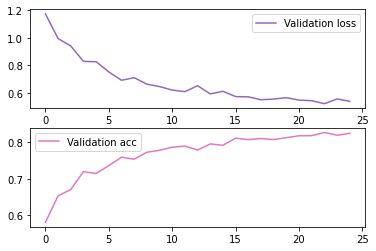

In [80]:
fig, (axs1, axs2) = plt.subplots(2)
axs1.plot(valid_loss_hist, "tab:purple", label="Validation loss")
axs1.legend()
axs2.plot(valid_acc_hist, "tab:pink", label="Validation acc")
axs2.legend()